# Pre-Processing and Training Data

## Remember

The purpose of this project is to build a predictive model for Economic index based on school demographics in NYC. This model will be used to provide guidance for NYC's education system plan and aim to decrease economic indexes by borough.








## The next step is to 

1. Load the data


2. Split the data 


3. Scale and ecode data if necessary


4. initiate the model 


5. Create the Pipeline


6. fit the pipeline


We are going to use PySpark Mlib

to train and prprocess our model.

We are also going to import the libraries we want to use first

In [741]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as e
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import keras
import keras.utils
from keras import utils as np_utils
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from pyspark.ml.feature import RobustScaler

# Initiate Spark

In [742]:
nyc_data_model = pd.read_csv('../data/nyc_data_modeling.csv')

In [743]:
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .config("spark.driver.bindAddress", "127.0.0.1") \
                    .getOrCreate()

In [744]:
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=SparkByExamples.com>

In [745]:
#sc.stop()

In [746]:
print("Spark Version: {}".format(sc.version))

Spark Version: 3.3.1


In [747]:
print("Spark Version: {}".format(sc.pythonVer))

Spark Version: 3.9


In [748]:
print("Spark Version: {}".format(sc.master))

Spark Version: local[1]


# Load data

In [749]:
PATH = '../data/nyc_data_modeling.csv'

In [750]:
# Pandas

nyc_pandas = pd.read_csv(PATH).iloc[:,1:]

In [751]:
#Spark
nyc_spark = spark.read.csv(PATH, header=True, inferSchema=True)

PySpark makes no such inferences. By default, PySpark will treat the header as the first row and all columns as string variables. To prevent PySpark from making any false assumptions, the user must assign values to the header and inferSchema parameters.

In [752]:
nyc_pandas.head()

,Year,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,Borough,District Number,Economic Support,Pre School,Elementary School,Middle School,High School
0,2016-17,95,14,51,105,3,1,4,0,51,12,88.2,Manhattan,1,Need Support,45,133,0,0
1,2017-18,91,20,52,110,1,1,6,0,49,8,89.0,Manhattan,1,Need Support,45,145,0,0
2,2018-19,89,24,48,95,0,1,6,0,39,8,88.8,Manhattan,1,Need Support,33,141,0,0
3,2019-20,96,27,56,96,0,2,9,0,46,17,86.7,Manhattan,1,Need Support,43,147,0,0
4,2020-21,92,26,53,102,1,0,11,0,43,21,85.6,Manhattan,1,Need Support,46,147,0,0


Since PySpark implements lazy execution, it requires a trigger that derives the results of any operation. In this case, the show function acts as the trigger, letting the user view the loaded dataset.

In [753]:
nyc_pandas.describe()

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,District Number,Pre School,Elementary School,Middle School,High School
count,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000
mean,301.697241,95.272113,149.827898,239.106009,6.453594,6.534300,86.237321,2.524376,122.522303,80.493620,73.083172,27.062820,60.735304,220.988439,127.866834,176.365034
std,252.467601,217.404728,166.121062,223.101691,12.272638,14.409499,180.892501,8.999338,97.894632,106.569319,20.205806,26.072237,75.858914,260.187174,266.269458,467.812553
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,5.000000,41.000000,90.000000,1.000000,1.000000,6.000000,0.000000,67.000000,18.000000,63.300000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,245.000000,17.000000,102.000000,181.000000,2.000000,3.000000,15.000000,0.000000,99.000000,44.000000,79.200000,19.000000,46.000000,153.000000,0.000000,0.000000
75%,359.000000,81.000000,192.000000,313.000000,7.000000,7.000000,78.000000,1.000000,146.000000,100.000000,88.600000,29.000000,104.000000,389.000000,187.000000,248.000000
max,3635.000000,3671.000000,1493.000000,2056.000000,181.000000,355.000000,3104.000000,234.000000,925.000000,1168.000000,95.000000,84.000000,1328.000000,1688.000000,2265.000000,6040.000000


In [754]:
nyc_spark.describe().show()

22/12/02 10:52:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
 Schema: _c0, Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
Expected: _c0 but found: 
CSV file: file:///Users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/data/nyc_data_modeling.csv


+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+----------------------------+---------------------------+-------------------+-------------+------------------+----------------+-----------------+------------------+------------------+------------------+
|summary|              _c0|   Year|            # Male|           # Asian|           # Black|        # Hispanic|    # Multi-Racial| # Native American|          # White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|      Borough|   District Number|Economic Support|       Pre School| Elementary School|     Middle School|       High School|
+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+---

There is a random column in spark dataframe. Let's get rid of it.

In [755]:
nyc_spark = nyc_spark.drop('_c0')

We can also get rid of the categorical column economic support since we can directly predit the economic need index and deteremine which category it fits. 

In [756]:
nyc_spark = nyc_spark.drop('Economic Support')

In [757]:
print(nyc_spark.printSchema())

root
 |-- Year: string (nullable = true)
 |-- # Male: integer (nullable = true)
 |-- # Asian: integer (nullable = true)
 |-- # Black: integer (nullable = true)
 |-- # Hispanic: integer (nullable = true)
 |-- # Multi-Racial: integer (nullable = true)
 |-- # Native American: integer (nullable = true)
 |-- # White: integer (nullable = true)
 |-- # Missing Race/Ethnicity Data: integer (nullable = true)
 |-- # Students with Disabilities: integer (nullable = true)
 |-- # English Language Learners: integer (nullable = true)
 |-- Economic Need Index: double (nullable = true)
 |-- Borough: string (nullable = true)
 |-- District Number: integer (nullable = true)
 |-- Pre School: integer (nullable = true)
 |-- Elementary School: integer (nullable = true)
 |-- Middle School: integer (nullable = true)
 |-- High School: integer (nullable = true)

None


In [758]:
columns_to_drop = ['Economic Support']
nyc_spark = nyc_spark.drop(*columns_to_drop)
nyc_pandas = nyc_pandas.drop(['Economic Support'], axis=1)

### String Indexer -> OHEncode

In [759]:
indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
nyc_spark_index = indexer.fit(nyc_spark).transform(nyc_spark)

In [760]:
ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
ohe_encoder_index = ohe_encoder.fit(nyc_spark_index).transform(nyc_spark_index)

In [761]:
ohe_encoder_index.show()

+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+-----------+-------------+---------------------+----------+-------------+-------------------+-------------+
|   Year|# Male|# Asian|# Black|# Hispanic|# Multi-Racial|# Native American|# White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|  Borough|District Number|Pre School|Elementary School|Middle School|High School|Borough_label|District Number_label|Year_label|  Borough_ohe|District Number_ohe|     Year_ohe|
+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+----

### Scale the Data

In [762]:
vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       '# Native American', '# White', '# Missing Race/Ethnicity Data',
       '# Students with Disabilities', '# English Language Learners', 'Pre School',
       'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

vec_assemb = vec_assembler.transform(ohe_encoder_index)
vec_assemb

DataFrame[Year: string, # Male: int, # Asian: int, # Black: int, # Hispanic: int, # Multi-Racial: int, # Native American: int, # White: int, # Missing Race/Ethnicity Data: int, # Students with Disabilities: int, # English Language Learners: int, Economic Need Index: double, Borough: string, District Number: int, Pre School: int, Elementary School: int, Middle School: int, High School: int, Borough_label: double, District Number_label: double, Year_label: double, Borough_ohe: vector, District Number_ohe: vector, Year_ohe: vector, feature: vector]

In [763]:
from pyspark.ml.feature import StandardScaler
scaler_sc =  StandardScaler().setInputCol('feature').setOutputCol("feature_scaled")
vec_scaled_train_sc = scaler.fit(vec_assemb).transform(vec_assemb)

In [764]:
from pyspark.ml.feature import RobustScaler
scaler_rc =  RobustScaler().setInputCol('feature').setOutputCol("feature_scaled")
vec_scaled_train_rc = scaler_rc.fit(vec_assemb).transform(vec_assemb)

## Split the data

In [765]:
(train_df, test_df) = vec_scaled_train_sc.randomSplit([0.8, 0.2])
(train_df_rc, test_df_rc) = vec_scaled_train_rc.randomSplit([0.8, 0.2])

## Model 1. Linear Regression

The model I chose is linear Regression and I chose it since it is a classic regression model with linear algorithm. Simply all the calculation of the functions add up to the dependent variable.

I am going to use the following parameters and tune it.

1. elasticNetParam = 1.0
by setting it equal to 1.0, it means that it's lasso regression which is L1.

I chose L1 penalization over L2 because I have a lot of outliers in my data set. Since L1 takes the manhattan distance meaning it is penalizing the !absolute value! of the weights so it is more robust to outliers.

The down side of L1 would be the case when we have highly correlated features, the L1 norm would select only 1 of the features from the group of correlated features in an arbitrary nature so lasso regression also acts as a feature selector.

0.5 would be the mix of L1 and L2.

In general, Lasso regression (Linear Regression with L1 regularization) would produce a model that is highly interpretable, and only uses a subset of input features, thus reducing the complexity of the model.

2. MaxItr = 100,150,200,250
This has no reason. The higher the iteration, prone to overfit. 

3. regParam
This is unknown. We have to try multiple values


In [766]:
metric_list_sc = []
metric_list_rc = []

In [767]:
linear_regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Tune the model

In [768]:
# alpha = 0 - penalty L2
paramGrid = (ParamGridBuilder()
               .addGrid(linear_regressor.maxIter, [100,150,200,250])
               .addGrid(linear_regressor.elasticNetParam, [0.1,0.5,1.0])
               .addGrid(linear_regressor.regParam, [0.3,0.6,0.9])
               .build())

In [769]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="mae")

regressorcv = CrossValidator(estimator = linear_regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)

linear_regression_cv = regressorcv.fit(train_df)

In [770]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="mae")

regressorcv = CrossValidator(estimator = linear_regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)

linear_regression_cv_rc = regressorcv.fit(train_df_rc)

## Evaluate¶

In [771]:
lr_regressor_predictions = linear_regression_cv.transform(test_df)
print('Standard Scaling MAE:', evaluator.evaluate(lr_regressor_predictions))
metric_list_sc.append(evaluator.evaluate(lr_regressor_predictions))

Standard Scaling MAE: 7.6691484198204805


In [772]:
lr_regressor_predictions = linear_regression_cv_rc.transform(test_df_rc)
print('Robust Scaling MAE:', evaluator.evaluate(lr_regressor_predictions))
metric_list_rc.append(evaluator.evaluate(lr_regressor_predictions))

Robust Scaling MAE: 10.39921765869563


### Extra Notes about preprocessing

Sparks one hot encoder: have to convert String to index and then convert again to one hot encode.

sklearns one hot encoder: converts directly to index from String

so basically, the above solution is splitting the data after encoding and scaling and the bottom solution is I split the data first and encoded. According to the evaluation metrics, the score doesn't have a difference at all. Therefore, I prefer using the top method which contains less code. 

Steps:
Encode -> Scale(Normalize) -> Split -> Model -> Evaluate

### Encoding

In [773]:
#from pyspark.ml.feature import OneHotEncoder
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.feature import StandardScaler

#indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
#label_df_train = indexer.fit(train_df).transform(train_df)
#label_df_test = indexer.fit(test_df).transform(test_df)

In [774]:
#ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
#encoding_df_train = ohe_encoder.fit(label_df_train).transform(label_df_train)
#encoding_df_test = ohe_encoder.fit(label_df_test).transform(label_df_test)

### Scaling

In spark, when we scale, we have to perform vectorAssembler to perform Feature Vectorization meaning all the columns should be vectorized. 

In [775]:
#vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       #'# Native American', '# White', '# Missing Race/Ethnicity Data',
       #'# Students with Disabilities', '# English Language Learners', 'Pre School',
       #'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

#vec_assemb_train = vec_assembler.transform(encoding_df_train)
#vec_assemb_test = vec_assembler.transform(encoding_df_test)

In [776]:
#scaler = StandardScaler(inputCol='feature', outputCol='feature_scaled', withMean=True, withStd=True)
#vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb_train)
#vec_scaled_test = scaler.fit(vec_assemb).transform(vec_assemb_test)

### Create Model

In [777]:
#from pyspark.ml.regression import LinearRegression

#regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

In [778]:
#linear_model = regressor.fit(vec_scaled_train)

In [779]:
#print("Coefficients: " + str(linear_model.coefficients))
#print("\nIntercept: " + str(linear_model.intercept))
#trainSummary = linear_model.summary
#print("RMSE: %f" % trainSummary.rootMeanSquaredError)
#print("\nr2: %f" % trainSummary.r2)

In [780]:
#pred = linear_model.evaluate(vec_scaled_test)
#pred.predictions.toPandas().iloc[:,10:].head()

In [781]:
#print('‘MAE for test set:’', pred.meanAbsoluteError)
#print('MSE for test set:', pred.meanSquaredError)
#print('RMSE for test set:', pred.rootMeanSquaredError)
#print('R2-Score for test set:', pred.r2)

### Model 2: Decision tree Regression

I chose Decision tree Regression because it is

In [782]:
regressor = DecisionTreeRegressor(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Binning feature values

Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication.

Note that the maxBins parameter must be at least the maximum number of categories M for any categorical feature.

### Max depth

Increasing the depth leads to overfitting since it increases its complexity. 

## Tuning the model

In [783]:
paramGrid = (ParamGridBuilder()
               .addGrid(regressor.maxDepth, [2,5,10,2,30])
               .addGrid(regressor.maxBins, [10,20,40,80,100])
               .build())

### Evaluation

In [784]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="mae")

regressorcv = CrossValidator(estimator = regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)


In [785]:
tree_regressor_model = regressorcv.fit(train_df)

22/12/02 10:55:29 WARN DAGScheduler: Broadcasting large task binary with size 1087.9 KiB
22/12/02 10:55:29 WARN DAGScheduler: Broadcasting large task binary with size 1192.0 KiB
22/12/02 10:55:29 WARN DAGScheduler: Broadcasting large task binary with size 1281.9 KiB
22/12/02 10:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1358.8 KiB
22/12/02 10:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1423.5 KiB
22/12/02 10:55:31 WARN DAGScheduler: Broadcasting large task binary with size 1483.1 KiB
22/12/02 10:55:31 WARN DAGScheduler: Broadcasting large task binary with size 1535.2 KiB
22/12/02 10:55:31 WARN DAGScheduler: Broadcasting large task binary with size 1585.7 KiB
22/12/02 10:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1629.5 KiB
22/12/02 10:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1664.5 KiB
22/12/02 10:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1691.6 KiB
22/12/02 10:55:32 WAR

22/12/02 10:55:51 WARN DAGScheduler: Broadcasting large task binary with size 1017.8 KiB


22/12/02 10:55:53 WARN DAGScheduler: Broadcasting large task binary with size 1134.8 KiB
22/12/02 10:55:54 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB
22/12/02 10:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/12/02 10:55:56 WARN DAGScheduler: Broadcasting large task binary with size 1411.8 KiB
22/12/02 10:55:56 WARN DAGScheduler: Broadcasting large task binary with size 1484.1 KiB
22/12/02 10:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1544.9 KiB
22/12/02 10:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1594.0 KiB
22/12/02 10:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1638.2 KiB
22/12/02 10:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1674.4 KiB
22/12/02 10:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1698.8 KiB
22/12/02 10:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1716.3 KiB
22/12/02 10:55:59 WAR

22/12/02 10:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1025.3 KiB
22/12/02 10:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1147.0 KiB
22/12/02 10:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1253.3 KiB
22/12/02 10:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1347.5 KiB
22/12/02 10:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1429.5 KiB
22/12/02 10:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1494.3 KiB
22/12/02 10:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1549.3 KiB
22/12/02 10:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1596.0 KiB
22/12/02 10:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1637.8 KiB
22/12/02 10:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1674.8 KiB
22/12/02 10:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
22/12/02 10:56:10 WAR

22/12/02 10:56:27 WARN DAGScheduler: Broadcasting large task binary with size 1047.2 KiB


22/12/02 10:56:28 WARN DAGScheduler: Broadcasting large task binary with size 1167.0 KiB
22/12/02 10:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1274.0 KiB
22/12/02 10:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1364.6 KiB
22/12/02 10:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1444.2 KiB
22/12/02 10:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1513.3 KiB
22/12/02 10:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1571.8 KiB
22/12/02 10:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1622.0 KiB
22/12/02 10:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1661.6 KiB
22/12/02 10:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1690.3 KiB
22/12/02 10:56:33 WARN DAGScheduler: Broadcasting large task binary with size 1714.1 KiB
22/12/02 10:56:33 WARN DAGScheduler: Broadcasting large task binary with size 1729.4 KiB
22/12/02 10:56:33 WAR

22/12/02 10:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1084.1 KiB
22/12/02 10:57:24 WARN DAGScheduler: Broadcasting large task binary with size 1204.4 KiB
22/12/02 10:57:25 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
22/12/02 10:57:25 WARN DAGScheduler: Broadcasting large task binary with size 1389.2 KiB
22/12/02 10:57:26 WARN DAGScheduler: Broadcasting large task binary with size 1467.2 KiB
22/12/02 10:57:26 WARN DAGScheduler: Broadcasting large task binary with size 1538.9 KiB
22/12/02 10:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1599.4 KiB
22/12/02 10:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
22/12/02 10:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1682.5 KiB
22/12/02 10:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1706.2 KiB
22/12/02 10:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1725.0 KiB
22/12/02 10:57:28 WAR

22/12/02 10:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB
22/12/02 10:59:24 WARN DAGScheduler: Broadcasting large task binary with size 1154.3 KiB
22/12/02 10:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1256.9 KiB


22/12/02 10:59:26 WARN DAGScheduler: Broadcasting large task binary with size 1346.1 KiB
22/12/02 10:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1420.5 KiB
22/12/02 10:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1480.1 KiB
22/12/02 10:59:28 WARN DAGScheduler: Broadcasting large task binary with size 1534.4 KiB
22/12/02 10:59:29 WARN DAGScheduler: Broadcasting large task binary with size 1582.6 KiB
22/12/02 10:59:29 WARN DAGScheduler: Broadcasting large task binary with size 1623.1 KiB
22/12/02 10:59:30 WARN DAGScheduler: Broadcasting large task binary with size 1653.1 KiB
22/12/02 10:59:30 WARN DAGScheduler: Broadcasting large task binary with size 1678.1 KiB
22/12/02 10:59:31 WARN DAGScheduler: Broadcasting large task binary with size 1699.3 KiB
22/12/02 10:59:31 WARN DAGScheduler: Broadcasting large task binary with size 1715.7 KiB
22/12/02 10:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1731.6 KiB
22/12/02 10:59:32 WAR

22/12/02 11:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1024.0 KiB
22/12/02 11:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1147.8 KiB


22/12/02 11:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1259.5 KiB
22/12/02 11:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1354.8 KiB
22/12/02 11:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1436.4 KiB
22/12/02 11:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1506.9 KiB
22/12/02 11:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1568.1 KiB
22/12/02 11:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
22/12/02 11:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1649.0 KiB
22/12/02 11:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1677.6 KiB
22/12/02 11:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1698.6 KiB
22/12/02 11:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1717.9 KiB
22/12/02 11:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1731.4 KiB
22/12/02 11:00:29 WAR

In [786]:
regressor_predictions = tree_regressor_model.transform(test_df)
print('MAE:', evaluator.evaluate(regressor_predictions))
metric_list_sc.append(evaluator.evaluate(regressor_predictions))

MAE: 5.993928619908633


In [787]:
tree_regressor_model = regressorcv.fit(train_df_rc)
regressor_predictions = tree_regressor_model.transform(test_df_rc)
print('MAE:', evaluator.evaluate(regressor_predictions))
metric_list_rc.append(evaluator.evaluate(regressor_predictions))

22/12/02 11:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1128.4 KiB
22/12/02 11:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1252.7 KiB
22/12/02 11:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1355.0 KiB
22/12/02 11:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB
22/12/02 11:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1504.0 KiB
22/12/02 11:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1562.8 KiB
22/12/02 11:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1613.7 KiB
22/12/02 11:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1650.1 KiB
22/12/02 11:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1676.5 KiB
22/12/02 11:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1692.9 KiB
22/12/02 11:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
22/12/02 11:00:51 WAR

22/12/02 11:01:18 WARN DAGScheduler: Broadcasting large task binary with size 1107.5 KiB
22/12/02 11:01:19 WARN DAGScheduler: Broadcasting large task binary with size 1233.5 KiB
22/12/02 11:01:19 WARN DAGScheduler: Broadcasting large task binary with size 1343.7 KiB
22/12/02 11:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1440.6 KiB
22/12/02 11:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1515.2 KiB
22/12/02 11:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1569.3 KiB
22/12/02 11:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1611.6 KiB
22/12/02 11:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1647.1 KiB
22/12/02 11:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1672.1 KiB
22/12/02 11:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1691.3 KiB
22/12/02 11:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1704.7 KiB
22/12/02 11:01:23 WAR

22/12/02 11:02:10 WARN DAGScheduler: Broadcasting large task binary with size 1109.5 KiB
22/12/02 11:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1223.8 KiB
22/12/02 11:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1321.3 KiB
22/12/02 11:02:12 WARN DAGScheduler: Broadcasting large task binary with size 1403.2 KiB
22/12/02 11:02:12 WARN DAGScheduler: Broadcasting large task binary with size 1472.6 KiB
22/12/02 11:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1534.1 KiB
22/12/02 11:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1585.1 KiB
22/12/02 11:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1619.2 KiB
22/12/02 11:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1644.4 KiB
22/12/02 11:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1664.4 KiB
22/12/02 11:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1681.0 KiB
22/12/02 11:02:14 WAR

22/12/02 11:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1034.0 KiB


22/12/02 11:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1147.2 KiB
22/12/02 11:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1254.9 KiB
22/12/02 11:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1354.4 KiB
22/12/02 11:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1440.5 KiB
22/12/02 11:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1507.1 KiB
22/12/02 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 1557.3 KiB
22/12/02 11:02:57 WARN DAGScheduler: Broadcasting large task binary with size 1601.8 KiB
22/12/02 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1637.2 KiB
22/12/02 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1666.4 KiB
22/12/02 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1685.3 KiB
22/12/02 11:02:59 WARN DAGScheduler: Broadcasting large task binary with size 1698.8 KiB
22/12/02 11:02:59 WAR

22/12/02 11:03:05 WARN DAGScheduler: Broadcasting large task binary with size 1049.5 KiB


22/12/02 11:03:05 WARN DAGScheduler: Broadcasting large task binary with size 1160.8 KiB
22/12/02 11:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1263.8 KiB
22/12/02 11:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1352.2 KiB
22/12/02 11:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1429.7 KiB
22/12/02 11:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1488.8 KiB
22/12/02 11:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1540.6 KiB
22/12/02 11:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1583.5 KiB
22/12/02 11:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1618.6 KiB
22/12/02 11:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1647.7 KiB
22/12/02 11:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1671.0 KiB
22/12/02 11:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1689.4 KiB
22/12/02 11:03:10 WAR

22/12/02 11:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1125.8 KiB
22/12/02 11:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1250.1 KiB
22/12/02 11:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1362.6 KiB
22/12/02 11:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1460.3 KiB
22/12/02 11:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1536.7 KiB
22/12/02 11:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1591.1 KiB
22/12/02 11:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1638.7 KiB
22/12/02 11:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1676.5 KiB
22/12/02 11:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1706.2 KiB
22/12/02 11:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1726.2 KiB
22/12/02 11:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1736.8 KiB
22/12/02 11:04:00 WAR

22/12/02 11:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB


22/12/02 11:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1134.8 KiB
22/12/02 11:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1253.5 KiB
22/12/02 11:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB
22/12/02 11:04:49 WARN DAGScheduler: Broadcasting large task binary with size 1456.9 KiB
22/12/02 11:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1541.8 KiB
22/12/02 11:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1608.8 KiB
22/12/02 11:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1661.5 KiB
22/12/02 11:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1697.8 KiB
22/12/02 11:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1719.8 KiB
22/12/02 11:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1733.6 KiB
22/12/02 11:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1742.2 KiB
22/12/02 11:04:51 WAR

In [788]:
metric_list_sc

[7.6691484198204805, 5.993928619908633]

In [789]:
metric_list_rc

[10.39921765869563, 6.569885472179054]

## Model 3: Multilayer Perceptron

I am going to be using Keras for this. The reaason why i chose this model is to try out with the multi layer regression

This model is used for accuracy purposes sacrificing speed compared to the two above models. Since it performs better in large data than the normal linear regression and decision tree regressor, I will be using it. 

In [790]:
x = nyc_pandas.drop(['Economic Need Index'],axis=1)
y = nyc_pandas['Economic Need Index']

### Split the data

In [791]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state= 42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 40)

In [792]:
temp_columns = x_train.columns.tolist()

#index of desired column to move
index = x_train.columns.get_loc('Borough')
temp_columns = temp_columns[0:index]+temp_columns[index+1:]+temp_columns[index:index+1]

In [793]:
index = x_train.columns.get_loc('Year')

#Move to the last
temp_columns.pop(index)

'Year'

In [794]:
temp_columns.append('Year')

In [795]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'District Number',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year']

In [796]:
index1 = temp_columns.index('District Number')

temp_columns.pop(index1)

'District Number'

In [797]:
temp_columns.append('District Number')

In [798]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year',
 'District Number']

In [799]:
x_train = x_train[temp_columns]
x_val = x_val[temp_columns]
x_test = x_test[temp_columns]

In [800]:
x_train

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Pre School,Elementary School,Middle School,High School,Borough,Year,District Number
7891,230,14,93,174,0,20,7,0,307,98,1,0,66,241,Bronx,2020-21,75
1469,271,4,121,389,2,1,16,0,125,112,121,412,0,0,Bronx,2020-21,7
4089,75,8,91,23,1,0,10,0,41,27,0,0,133,0,Brooklyn,2018-19,17
3413,176,15,285,31,1,5,12,14,50,4,0,0,0,363,Brooklyn,2018-19,13
3235,262,4,133,319,2,6,6,1,150,60,0,0,0,471,Bronx,2018-19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7839,367,117,81,210,5,6,64,0,483,207,93,235,97,58,Queens,2018-19,75
3603,330,26,143,485,1,6,44,14,132,32,0,0,0,719,Brooklyn,2020-21,14
5959,584,771,50,124,12,1,202,0,151,89,0,0,1160,0,Queens,2017-18,26
5426,625,681,7,486,1,8,36,0,183,357,203,1016,0,0,Queens,2017-18,24


### Encode

### x_train

In [801]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(x_train[['Year','Borough','District Number']])

print(encoder.categories_)
encoded_x_train = encoder.transform(x_train[['Year','Borough','District Number']]).toarray()

print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train = pd.DataFrame(encoded_x_train, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train.head()

print(encoded_x_train.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### x_val

In [802]:
encoder = OneHotEncoder()
encoder.fit(x_val[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_val = encoder.transform(x_val[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val = pd.DataFrame(encoded_x_val, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val.head()
print(encoded_x_val.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

In [803]:
encoder = OneHotEncoder()
encoder.fit(x_test[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_test = encoder.transform(x_test[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test = pd.DataFrame(encoded_x_test, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test.head()
print(encoded_x_test.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

## Scale

### Standard Scaler

In [804]:
from sklearn.preprocessing import StandardScaler
def standard_scaling():
    column_insert = x_train.loc[:,:'High School'].columns
    sc = StandardScaler()
    x_train_scaled_sc = pd.DataFrame(sc.fit_transform(x_train.loc[:,:'High School']),columns = column_insert)
    x_test_scaled_sc = pd.DataFrame(sc.fit_transform(x_test.loc[:,:'High School']),columns = column_insert)
    x_val_scaled_sc = pd.DataFrame(sc.fit_transform(x_val.loc[:,:'High School']),columns=column_insert)
    return x_train_scaled_sc,x_test_scaled_sc,x_val_scaled_sc

x_train_scaled_sc, x_test_scaled_sc, x_val_scaled_sc = standard_scaling()
print(x_train_scaled_sc.shape)
print(x_test_scaled_sc.shape)
print(x_val_scaled_sc.shape)

(7335, 14)
(1834, 14)
(1834, 14)


### Robust Scaler

In [805]:
from sklearn.preprocessing import RobustScaler
def robust_scaling():
    column_insert = x_train.loc[:,:'High School'].columns
    rc = RobustScaler()
    x_train_scaled_rc = pd.DataFrame(rc.fit_transform(x_train.loc[:,:'High School']),columns = column_insert)
    x_test_scaled_rc = pd.DataFrame(rc.fit_transform(x_test.loc[:,:'High School']),columns = column_insert)
    x_val_scaled_rc = pd.DataFrame(rc.fit_transform(x_val.loc[:,:'High School']),columns=column_insert)
    return x_train_scaled_rc,x_test_scaled_rc,x_val_scaled_rc

x_train_scaled_rc,x_test_scaled_rc,x_val_scaled_rc = robust_scaling()

print(x_train_scaled_rc.shape)
print(x_test_scaled_rc.shape)
print(x_val_scaled_rc.shape)

(7335, 14)
(1834, 14)
(1834, 14)


## Concatenate with the encoded columns

### Standard scaling + One Hot Encoding

In [806]:
final_df_x_train_sc = pd.concat([encoded_x_train, x_train_scaled_sc],axis=1)
final_df_x_val_sc = pd.concat([encoded_x_val, x_val_scaled_sc],axis=1)
final_df_x_test_sc = pd.concat([encoded_x_test, x_test_scaled_sc],axis=1)

### Robust scaling + One Hot Encoding

In [807]:
final_df_x_train_rc = pd.concat([encoded_x_train, x_train_scaled_rc],axis=1)
final_df_x_val_rc = pd.concat([encoded_x_val, x_val_scaled_rc],axis=1)
final_df_x_test_rc = pd.concat([encoded_x_test, x_test_scaled_rc],axis=1)

## Initialize model

### Compile with Standard Scaled data first

In [808]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = final_df_x_train_sc.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'sgd', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(final_df_x_train_sc, y_train, batch_size = 64, epochs= 50, validation_data=(final_df_x_val_sc, y_val))

Epoch 1/50
115/115 [==============================] - 1s 4ms/step - loss: 69.6674 - root_mean_squared_error: 72.6882 - val_loss: 63.8719 - val_root_mean_squared_error: 67.0489
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 41.1292 - root_mean_squared_error: 47.5354 - val_loss: 12.9997 - val_root_mean_squared_error: 15.9411
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 8.7983 - root_mean_squared_error: 12.1498 - val_loss: 7.6305 - val_root_mean_squared_error: 10.5434
Epoch 4/50
115/115 [==============================] - 0s 2ms/step - loss: 7.4052 - root_mean_squared_error: 10.4392 - val_loss: 7.0766 - val_root_mean_squared_error: 9.9115
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 7.0023 - root_mean_squared_error: 9.8587 - val_loss: 6.7603 - val_root_mean_squared_error: 9.4740
Epoch 6/50
115/115 [==============================] - 0s 2ms/step - loss: 6.7654 - root_mean_squared_error: 9.5559 - val_loss: 6.

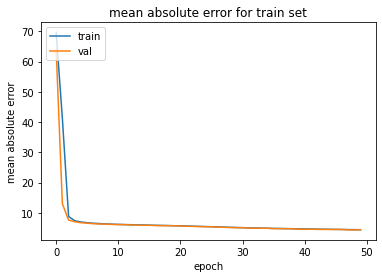

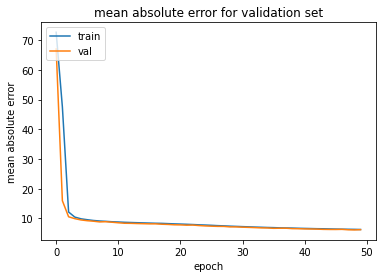

In [809]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mean absolute error for train set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('mean absolute error for validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I can see that my model is over fitting. 

I chose the activatioon function ReLU in the hidden layer. It is a commonly used activation function where if the input x is negative, then a value 0 is returned. 

By analysis, we find that compared with ADAM, SGD is more locally unstable and is more likely to converge to the minima at the flat or asymmetric basins/valleys which often have better generalization performance over other type minima. So our results can explain the better generalization performance of SGD over ADAM. SO i didnt use adams

Source: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

In [810]:
# getting the metrics

def metrics_for_mlp():
    y_pred = model.predict(final_df_x_test_sc).ravel()
    mae = mean_squared_error(y_test, y_pred, squared = False)
    return mae

In [811]:
metrics_for_mlp()

58/58 [==============================] - 0s 2ms/step


6.9574809186837525

In [812]:
metric_list_sc.append(round(7,2))

### Robust Scaling

In [813]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = final_df_x_train_rc.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'sgd', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(final_df_x_train_rc, y_train, batch_size = 64, epochs= 50, validation_data=(final_df_x_val_rc, y_val))

Epoch 1/50
115/115 [==============================] - 1s 3ms/step - loss: 62.4174 - mean_absolute_error: 62.4174 - val_loss: 53.3584 - val_mean_absolute_error: 53.3584
Epoch 2/50
115/115 [==============================] - 0s 2ms/step - loss: 32.8864 - mean_absolute_error: 32.8864 - val_loss: 12.4295 - val_mean_absolute_error: 12.4295
Epoch 3/50
115/115 [==============================] - 0s 2ms/step - loss: 9.0618 - mean_absolute_error: 9.0618 - val_loss: 7.6041 - val_mean_absolute_error: 7.6041
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 7.5790 - mean_absolute_error: 7.5790 - val_loss: 7.7425 - val_mean_absolute_error: 7.7425
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 7.2913 - mean_absolute_error: 7.2913 - val_loss: 7.5943 - val_mean_absolute_error: 7.5943
Epoch 6/50
115/115 [==============================] - 0s 2ms/step - loss: 7.0108 - mean_absolute_error: 7.0108 - val_loss: 6.8568 - val_mean_absolute_error: 6.8568
Epoch 7/

In [814]:
def metrics_for_mlp():
    y_pred = model.predict(final_df_x_test_rc).ravel()
    mae = mean_squared_error(y_test, y_pred, squared = False)
    return mae

In [815]:
metrics_for_mlp()

58/58 [==============================] - 0s 1ms/step


7.1692734421786914

In [816]:
metric_list_rc.append(round(9.426,2))

### Cat Boost

In [817]:
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

### Standard Scaler

In [818]:
def cb_objective(trial):
    learning_rate = trial.suggest_float('learning_rate',0.01,0.2)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    depth = trial.suggest_int('depth', 1,10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3,15)
    
    cb = CatBoostRegressor(learning_rate = learning_rate, 
                            n_estimators = n_estimators,
                            depth = depth, 
                            l2_leaf_reg= l2_leaf_reg, 
                            loss_function = 'MAE')
    
    cb.fit(final_df_x_train_sc, y_train)
    
    y_pred = cb.predict(final_df_x_val_sc)
    
    return mean_absolute_error(y_val, y_pred)

study = optuna.create_study(direction = 'minimize')
study.optimize(cb_objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-12-02 11:05:23,912] A new study created in memory with name: no-name-79e9d887-7bf6-4b02-8cdf-05abe07edbaf


0:	learn: 14.1453047	total: 7.74ms	remaining: 3.15s
1:	learn: 13.2076334	total: 10.6ms	remaining: 2.15s
2:	learn: 12.2364509	total: 12.7ms	remaining: 1.72s
3:	learn: 11.4203323	total: 15.1ms	remaining: 1.52s
4:	learn: 10.8186600	total: 17ms	remaining: 1.37s
5:	learn: 10.2634245	total: 18.7ms	remaining: 1.25s
6:	learn: 9.7608260	total: 20.6ms	remaining: 1.18s
7:	learn: 9.3288332	total: 22.8ms	remaining: 1.14s
8:	learn: 8.9371887	total: 24.8ms	remaining: 1.1s
9:	learn: 8.5599471	total: 26.8ms	remaining: 1.07s
10:	learn: 8.2458756	total: 28.7ms	remaining: 1.03s
11:	learn: 7.9952056	total: 30.6ms	remaining: 1.01s
12:	learn: 7.7168742	total: 32.5ms	remaining: 986ms
13:	learn: 7.4783650	total: 34.2ms	remaining: 963ms
14:	learn: 7.3074590	total: 36.2ms	remaining: 950ms
15:	learn: 7.1232230	total: 38ms	remaining: 931ms
16:	learn: 6.9529916	total: 39.7ms	remaining: 913ms
17:	learn: 6.7916597	total: 41.4ms	remaining: 898ms
18:	learn: 6.6592409	total: 43.2ms	remaining: 885ms
19:	learn: 6.5326101	

[I 2022-12-02 11:05:25,214] Trial 0 finished with value: 3.3532628921879954 and parameters: {'learning_rate': 0.11579856675138939, 'n_estimators': 408, 'depth': 4, 'l2_leaf_reg': 9}. Best is trial 0 with value: 3.3532628921879954.


407:	learn: 3.1082907	total: 1.08s	remaining: 0us
0:	learn: 15.0168485	total: 1.74ms	remaining: 796ms
1:	learn: 14.8334414	total: 3.65ms	remaining: 829ms
2:	learn: 14.6128705	total: 6.04ms	remaining: 914ms
3:	learn: 14.4156570	total: 7.55ms	remaining: 855ms
4:	learn: 14.2403210	total: 8.86ms	remaining: 801ms
5:	learn: 14.0484567	total: 10.3ms	remaining: 772ms
6:	learn: 13.9005343	total: 12.1ms	remaining: 775ms
7:	learn: 13.7347488	total: 14.5ms	remaining: 815ms
8:	learn: 13.5885440	total: 15.9ms	remaining: 793ms
9:	learn: 13.4591105	total: 17.6ms	remaining: 788ms
10:	learn: 13.3116014	total: 19.3ms	remaining: 782ms
11:	learn: 13.1701909	total: 20.7ms	remaining: 769ms
12:	learn: 13.0445684	total: 22.2ms	remaining: 760ms
13:	learn: 12.9196915	total: 24.2ms	remaining: 765ms
14:	learn: 12.8601099	total: 26.5ms	remaining: 782ms
15:	learn: 12.7539920	total: 29.3ms	remaining: 808ms
16:	learn: 12.6482263	total: 30.9ms	remaining: 799ms
17:	learn: 12.5318943	total: 32.6ms	remaining: 795ms
18:	le

[I 2022-12-02 11:05:26,141] Trial 1 finished with value: 6.401651025940382 and parameters: {'learning_rate': 0.036754045296027375, 'n_estimators': 457, 'depth': 1, 'l2_leaf_reg': 11}. Best is trial 0 with value: 3.3532628921879954.


424:	learn: 6.5143297	total: 696ms	remaining: 52.4ms
425:	learn: 6.5112384	total: 699ms	remaining: 50.8ms
426:	learn: 6.5090258	total: 701ms	remaining: 49.2ms
427:	learn: 6.5040015	total: 702ms	remaining: 47.6ms
428:	learn: 6.5010499	total: 703ms	remaining: 45.9ms
429:	learn: 6.4983315	total: 705ms	remaining: 44.3ms
430:	learn: 6.4956167	total: 707ms	remaining: 42.6ms
431:	learn: 6.4921964	total: 709ms	remaining: 41ms
432:	learn: 6.4879071	total: 711ms	remaining: 39.4ms
433:	learn: 6.4854701	total: 713ms	remaining: 37.8ms
434:	learn: 6.4826421	total: 714ms	remaining: 36.1ms
435:	learn: 6.4803232	total: 715ms	remaining: 34.4ms
436:	learn: 6.4783346	total: 717ms	remaining: 32.8ms
437:	learn: 6.4746750	total: 718ms	remaining: 31.1ms
438:	learn: 6.4711951	total: 719ms	remaining: 29.5ms
439:	learn: 6.4685966	total: 721ms	remaining: 27.9ms
440:	learn: 6.4665740	total: 722ms	remaining: 26.2ms
441:	learn: 6.4646730	total: 724ms	remaining: 24.6ms
442:	learn: 6.4616347	total: 725ms	remaining: 22

[I 2022-12-02 11:05:27,327] Trial 2 finished with value: 3.0696482794812905 and parameters: {'learning_rate': 0.18610124007011172, 'n_estimators': 311, 'depth': 5, 'l2_leaf_reg': 11}. Best is trial 2 with value: 3.0696482794812905.


302:	learn: 2.6720951	total: 1.01s	remaining: 26.7ms
303:	learn: 2.6696741	total: 1.01s	remaining: 23.3ms
304:	learn: 2.6687697	total: 1.02s	remaining: 20ms
305:	learn: 2.6668074	total: 1.02s	remaining: 16.7ms
306:	learn: 2.6629199	total: 1.02s	remaining: 13.3ms
307:	learn: 2.6605379	total: 1.02s	remaining: 9.98ms
308:	learn: 2.6548426	total: 1.03s	remaining: 6.65ms
309:	learn: 2.6515022	total: 1.03s	remaining: 3.32ms
310:	learn: 2.6490709	total: 1.03s	remaining: 0us
0:	learn: 13.6247013	total: 18ms	remaining: 8.38s
1:	learn: 12.2961008	total: 35.1ms	remaining: 8.15s
2:	learn: 11.1217715	total: 49.9ms	remaining: 7.7s
3:	learn: 10.1661094	total: 68.7ms	remaining: 7.93s
4:	learn: 9.3613623	total: 86.4ms	remaining: 7.97s
5:	learn: 8.6675549	total: 102ms	remaining: 7.84s
6:	learn: 8.0155352	total: 114ms	remaining: 7.5s
7:	learn: 7.5083011	total: 131ms	remaining: 7.51s
8:	learn: 7.0342433	total: 146ms	remaining: 7.4s
9:	learn: 6.6258448	total: 162ms	remaining: 7.38s
10:	learn: 6.2568787	tot

[I 2022-12-02 11:05:33,837] Trial 3 finished with value: 2.113990296141546 and parameters: {'learning_rate': 0.132335704044171, 'n_estimators': 466, 'depth': 9, 'l2_leaf_reg': 8}. Best is trial 3 with value: 2.113990296141546.


463:	learn: 1.1233340	total: 6.12s	remaining: 26.4ms
464:	learn: 1.1224963	total: 6.13s	remaining: 13.2ms
465:	learn: 1.1184680	total: 6.14s	remaining: 0us
0:	learn: 13.6435799	total: 2.48ms	remaining: 856ms
1:	learn: 12.3014974	total: 4.34ms	remaining: 747ms
2:	learn: 11.3649421	total: 6.58ms	remaining: 753ms
3:	learn: 10.4318000	total: 9.6ms	remaining: 821ms
4:	learn: 9.5874783	total: 11.6ms	remaining: 788ms
5:	learn: 9.0616680	total: 15.7ms	remaining: 891ms
6:	learn: 8.6047158	total: 20.5ms	remaining: 991ms
7:	learn: 8.1302999	total: 23.3ms	remaining: 983ms
8:	learn: 7.7326063	total: 27.9ms	remaining: 1.04s
9:	learn: 7.4456765	total: 31.2ms	remaining: 1.05s
10:	learn: 7.2448250	total: 33.6ms	remaining: 1.02s
11:	learn: 7.0582743	total: 37.1ms	remaining: 1.03s
12:	learn: 6.8920602	total: 39.1ms	remaining: 1s
13:	learn: 6.7355862	total: 41ms	remaining: 973ms
14:	learn: 6.5909944	total: 43.5ms	remaining: 959ms
15:	learn: 6.4780428	total: 47.6ms	remaining: 982ms
16:	learn: 6.3578727	tot

[I 2022-12-02 11:05:34,737] Trial 4 finished with value: 3.577848102611675 and parameters: {'learning_rate': 0.19166452828822889, 'n_estimators': 346, 'depth': 3, 'l2_leaf_reg': 12}. Best is trial 3 with value: 2.113990296141546.


329:	learn: 3.3841825	total: 705ms	remaining: 34.2ms
330:	learn: 3.3824418	total: 707ms	remaining: 32ms
331:	learn: 3.3806237	total: 709ms	remaining: 29.9ms
332:	learn: 3.3788547	total: 711ms	remaining: 27.8ms
333:	learn: 3.3772294	total: 713ms	remaining: 25.6ms
334:	learn: 3.3744281	total: 715ms	remaining: 23.5ms
335:	learn: 3.3734631	total: 717ms	remaining: 21.3ms
336:	learn: 3.3699716	total: 718ms	remaining: 19.2ms
337:	learn: 3.3658078	total: 721ms	remaining: 17.1ms
338:	learn: 3.3649456	total: 723ms	remaining: 14.9ms
339:	learn: 3.3639091	total: 724ms	remaining: 12.8ms
340:	learn: 3.3592604	total: 727ms	remaining: 10.7ms
341:	learn: 3.3569021	total: 729ms	remaining: 8.53ms
342:	learn: 3.3559915	total: 731ms	remaining: 6.39ms
343:	learn: 3.3553641	total: 733ms	remaining: 4.26ms
344:	learn: 3.3544670	total: 734ms	remaining: 2.13ms
345:	learn: 3.3532468	total: 737ms	remaining: 0us
0:	learn: 13.6424124	total: 2.21ms	remaining: 874ms
1:	learn: 12.2995854	total: 4ms	remaining: 789ms
2:	

[I 2022-12-02 11:05:35,968] Trial 5 finished with value: 3.5025077158828055 and parameters: {'learning_rate': 0.1918157614911806, 'n_estimators': 396, 'depth': 3, 'l2_leaf_reg': 15}. Best is trial 3 with value: 2.113990296141546.


372:	learn: 3.3045312	total: 965ms	remaining: 59.5ms
373:	learn: 3.3016003	total: 967ms	remaining: 56.9ms
374:	learn: 3.3011418	total: 969ms	remaining: 54.3ms
375:	learn: 3.2999955	total: 971ms	remaining: 51.6ms
376:	learn: 3.2966982	total: 973ms	remaining: 49ms
377:	learn: 3.2957264	total: 974ms	remaining: 46.4ms
378:	learn: 3.2948418	total: 976ms	remaining: 43.8ms
379:	learn: 3.2924671	total: 978ms	remaining: 41.2ms
380:	learn: 3.2911203	total: 980ms	remaining: 38.6ms
381:	learn: 3.2901986	total: 982ms	remaining: 36ms
382:	learn: 3.2864369	total: 984ms	remaining: 33.4ms
383:	learn: 3.2854189	total: 985ms	remaining: 30.8ms
384:	learn: 3.2833131	total: 987ms	remaining: 28.2ms
385:	learn: 3.2815951	total: 989ms	remaining: 25.6ms
386:	learn: 3.2794547	total: 991ms	remaining: 23ms
387:	learn: 3.2783646	total: 993ms	remaining: 20.5ms
388:	learn: 3.2773641	total: 994ms	remaining: 17.9ms
389:	learn: 3.2768070	total: 996ms	remaining: 15.3ms
390:	learn: 3.2747725	total: 999ms	remaining: 12.8ms

[I 2022-12-02 11:05:37,467] Trial 6 finished with value: 3.5529625348992946 and parameters: {'learning_rate': 0.06657576978201099, 'n_estimators': 481, 'depth': 4, 'l2_leaf_reg': 15}. Best is trial 3 with value: 2.113990296141546.


465:	learn: 3.3970265	total: 1.26s	remaining: 40.6ms
466:	learn: 3.3940660	total: 1.26s	remaining: 37.9ms
467:	learn: 3.3924001	total: 1.27s	remaining: 35.2ms
468:	learn: 3.3900718	total: 1.27s	remaining: 32.5ms
469:	learn: 3.3886056	total: 1.27s	remaining: 29.8ms
470:	learn: 3.3870584	total: 1.27s	remaining: 27.1ms
471:	learn: 3.3850430	total: 1.28s	remaining: 24.3ms
472:	learn: 3.3838152	total: 1.28s	remaining: 21.6ms
473:	learn: 3.3818388	total: 1.28s	remaining: 18.9ms
474:	learn: 3.3804697	total: 1.28s	remaining: 16.2ms
475:	learn: 3.3775125	total: 1.29s	remaining: 13.5ms
476:	learn: 3.3754648	total: 1.29s	remaining: 10.8ms
477:	learn: 3.3745445	total: 1.29s	remaining: 8.12ms
478:	learn: 3.3735928	total: 1.29s	remaining: 5.41ms
479:	learn: 3.3710614	total: 1.3s	remaining: 2.7ms
480:	learn: 3.3691999	total: 1.3s	remaining: 0us
0:	learn: 13.5078403	total: 18.7ms	remaining: 6.68s
1:	learn: 12.1027408	total: 33.4ms	remaining: 5.95s
2:	learn: 10.8747468	total: 46.9ms	remaining: 5.54s
3:

[I 2022-12-02 11:05:42,467] Trial 7 finished with value: 2.253517173591944 and parameters: {'learning_rate': 0.14211976826821426, 'n_estimators': 358, 'depth': 9, 'l2_leaf_reg': 8}. Best is trial 3 with value: 2.113990296141546.


357:	learn: 1.2073601	total: 4.74s	remaining: 0us
0:	learn: 14.9844217	total: 4.82ms	remaining: 1.78s
1:	learn: 14.7458031	total: 8.33ms	remaining: 1.54s
2:	learn: 14.4920129	total: 12.3ms	remaining: 1.51s
3:	learn: 14.2521513	total: 16.6ms	remaining: 1.52s
4:	learn: 14.0259074	total: 21.3ms	remaining: 1.56s
5:	learn: 13.7941252	total: 24.6ms	remaining: 1.5s
6:	learn: 13.5704416	total: 28.8ms	remaining: 1.5s
7:	learn: 13.3557226	total: 32ms	remaining: 1.45s
8:	learn: 13.1658935	total: 34.8ms	remaining: 1.4s
9:	learn: 12.9808322	total: 39.1ms	remaining: 1.41s
10:	learn: 12.7769346	total: 43.4ms	remaining: 1.42s
11:	learn: 12.5948838	total: 45.8ms	remaining: 1.37s
12:	learn: 12.4097469	total: 49ms	remaining: 1.35s
13:	learn: 12.2307115	total: 51.5ms	remaining: 1.31s
14:	learn: 12.0498232	total: 54.5ms	remaining: 1.29s
15:	learn: 11.8808087	total: 58.8ms	remaining: 1.3s
16:	learn: 11.7128379	total: 62.3ms	remaining: 1.3s
17:	learn: 11.5477717	total: 68.5ms	remaining: 1.34s
18:	learn: 11.4

[I 2022-12-02 11:05:43,892] Trial 8 finished with value: 4.204260931817794 and parameters: {'learning_rate': 0.023935263565868843, 'n_estimators': 371, 'depth': 5, 'l2_leaf_reg': 9}. Best is trial 3 with value: 2.113990296141546.


362:	learn: 4.1748384	total: 1.2s	remaining: 26.3ms
363:	learn: 4.1714648	total: 1.2s	remaining: 23ms
364:	learn: 4.1695772	total: 1.2s	remaining: 19.7ms
365:	learn: 4.1658316	total: 1.2s	remaining: 16.5ms
366:	learn: 4.1633740	total: 1.21s	remaining: 13.2ms
367:	learn: 4.1621684	total: 1.21s	remaining: 9.86ms
368:	learn: 4.1598182	total: 1.21s	remaining: 6.57ms
369:	learn: 4.1575174	total: 1.22s	remaining: 3.29ms
370:	learn: 4.1546204	total: 1.22s	remaining: 0us
0:	learn: 14.2400139	total: 4.68ms	remaining: 2.31s
1:	learn: 13.3992504	total: 10.1ms	remaining: 2.47s
2:	learn: 12.6436343	total: 13.8ms	remaining: 2.25s
3:	learn: 11.9289057	total: 17.2ms	remaining: 2.1s
4:	learn: 11.3354262	total: 19.7ms	remaining: 1.92s
5:	learn: 10.7757748	total: 24.2ms	remaining: 1.97s
6:	learn: 10.2683978	total: 29.2ms	remaining: 2.03s
7:	learn: 9.8251291	total: 33.9ms	remaining: 2.06s
8:	learn: 9.4216852	total: 39.2ms	remaining: 2.11s
9:	learn: 9.0419189	total: 43.4ms	remaining: 2.1s
10:	learn: 8.6593

[I 2022-12-02 11:05:45,651] Trial 9 finished with value: 3.0615402315423528 and parameters: {'learning_rate': 0.09433031454235959, 'n_estimators': 493, 'depth': 5, 'l2_leaf_reg': 3}. Best is trial 3 with value: 2.113990296141546.


477:	learn: 2.7314317	total: 1.49s	remaining: 46.8ms
478:	learn: 2.7297742	total: 1.49s	remaining: 43.6ms
479:	learn: 2.7289977	total: 1.5s	remaining: 40.5ms
480:	learn: 2.7282001	total: 1.5s	remaining: 37.4ms
481:	learn: 2.7274566	total: 1.5s	remaining: 34.3ms
482:	learn: 2.7246281	total: 1.5s	remaining: 31.1ms
483:	learn: 2.7233593	total: 1.51s	remaining: 28ms
484:	learn: 2.7209010	total: 1.51s	remaining: 24.9ms
485:	learn: 2.7192615	total: 1.51s	remaining: 21.8ms
486:	learn: 2.7183876	total: 1.51s	remaining: 18.7ms
487:	learn: 2.7166049	total: 1.52s	remaining: 15.5ms
488:	learn: 2.7149599	total: 1.52s	remaining: 12.4ms
489:	learn: 2.7139139	total: 1.52s	remaining: 9.32ms
490:	learn: 2.7132515	total: 1.52s	remaining: 6.21ms
491:	learn: 2.7109250	total: 1.53s	remaining: 3.11ms
492:	learn: 2.7105104	total: 1.53s	remaining: 0us
Best Score: 2.113990296141546
Best trial: {'learning_rate': 0.132335704044171, 'n_estimators': 466, 'depth': 9, 'l2_leaf_reg': 8}


In [819]:
cat = CatBoostRegressor(learning_rate= 0.08579408289616608, n_estimators= 392, depth= 10, l2_leaf_reg= 14)
cat.fit(final_df_x_train_sc, y_train)

y_pred = cat.predict(final_df_x_test_sc)
y_val_pred = cat.predict(final_df_x_val_sc)


mae_train = (np.sqrt(mean_absolute_error(y_train,y_train)))
mae_val = (np.sqrt(mean_absolute_error(y_val,y_val_pred)))
mae = (np.sqrt(mean_absolute_error(y_test,y_pred)))
r2 = r2_score(y_test,y_pred)

print("Testing Performance")
print('MAE train: {:.2f}'.format(mae_train))
print('MAE val : {:.2f}'.format(mae_val))
print('MAE test: {:.2f}'.format(mae))
print('r2:{:.2f}'.format(r2))

0:	learn: 19.2150835	total: 129ms	remaining: 50.4s
1:	learn: 18.2735980	total: 153ms	remaining: 29.8s
2:	learn: 17.2935285	total: 169ms	remaining: 21.9s
3:	learn: 16.4772513	total: 198ms	remaining: 19.2s
4:	learn: 15.6797587	total: 225ms	remaining: 17.4s
5:	learn: 15.0120904	total: 241ms	remaining: 15.5s
6:	learn: 14.4032869	total: 259ms	remaining: 14.2s
7:	learn: 13.8070096	total: 275ms	remaining: 13.2s
8:	learn: 13.2614960	total: 315ms	remaining: 13.4s
9:	learn: 12.7290170	total: 352ms	remaining: 13.5s
10:	learn: 12.2696230	total: 381ms	remaining: 13.2s
11:	learn: 11.8160991	total: 405ms	remaining: 12.8s
12:	learn: 11.4134882	total: 427ms	remaining: 12.5s
13:	learn: 10.9840080	total: 449ms	remaining: 12.1s
14:	learn: 10.6207710	total: 468ms	remaining: 11.8s
15:	learn: 10.3061197	total: 496ms	remaining: 11.7s
16:	learn: 9.9906847	total: 519ms	remaining: 11.4s
17:	learn: 9.6987918	total: 539ms	remaining: 11.2s
18:	learn: 9.4315762	total: 557ms	remaining: 10.9s
19:	learn: 9.1899561	tota

In [820]:
metric_list_sc.append(1.85)

In [821]:
def cb_objective(trial):
    learning_rate = trial.suggest_float('learning_rate',0.01,0.2)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    depth = trial.suggest_int('depth', 1,10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3,15)
    
    cb = CatBoostRegressor(learning_rate = learning_rate, 
                            n_estimators = n_estimators,
                            depth = depth, 
                            l2_leaf_reg= l2_leaf_reg, 
                            loss_function = 'MAE')
    
    cb.fit(final_df_x_train_rc, y_train)
    
    y_pred = cb.predict(final_df_x_val_rc)
    
    return mean_absolute_error(y_val, y_pred)

study = optuna.create_study(direction = 'minimize')
study.optimize(cb_objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-12-02 11:05:53,059] A new study created in memory with name: no-name-d156a43c-ea19-459d-a03d-fdc1a6646538


0:	learn: 14.4260944	total: 19.5ms	remaining: 2.68s
1:	learn: 13.6759650	total: 38.7ms	remaining: 2.65s
2:	learn: 13.0213961	total: 48.5ms	remaining: 2.2s
3:	learn: 12.4243907	total: 59.9ms	remaining: 2.02s
4:	learn: 11.8284452	total: 75.1ms	remaining: 2.01s
5:	learn: 11.3568811	total: 81.5ms	remaining: 1.81s
6:	learn: 10.8739030	total: 89.2ms	remaining: 1.68s
7:	learn: 10.4086590	total: 98.2ms	remaining: 1.61s
8:	learn: 9.9962705	total: 106ms	remaining: 1.53s
9:	learn: 9.6408946	total: 112ms	remaining: 1.45s
10:	learn: 9.2956550	total: 118ms	remaining: 1.38s
11:	learn: 8.9651077	total: 126ms	remaining: 1.33s
12:	learn: 8.6684261	total: 136ms	remaining: 1.31s
13:	learn: 8.3579544	total: 145ms	remaining: 1.29s
14:	learn: 8.1149519	total: 157ms	remaining: 1.29s
15:	learn: 7.8739068	total: 171ms	remaining: 1.31s
16:	learn: 7.6845913	total: 177ms	remaining: 1.27s
17:	learn: 7.4521067	total: 184ms	remaining: 1.24s
18:	learn: 7.2752861	total: 192ms	remaining: 1.21s
19:	learn: 7.0885305	total

[I 2022-12-02 11:05:54,121] Trial 0 finished with value: 3.543777858755049 and parameters: {'learning_rate': 0.0703658591285096, 'n_estimators': 139, 'depth': 7, 'l2_leaf_reg': 15}. Best is trial 0 with value: 3.543777858755049.


132:	learn: 3.5093303	total: 887ms	remaining: 40ms
133:	learn: 3.5028662	total: 896ms	remaining: 33.4ms
134:	learn: 3.4971533	total: 902ms	remaining: 26.7ms
135:	learn: 3.4855528	total: 908ms	remaining: 20ms
136:	learn: 3.4795731	total: 915ms	remaining: 13.4ms
137:	learn: 3.4732479	total: 921ms	remaining: 6.67ms
138:	learn: 3.4633549	total: 926ms	remaining: 0us
0:	learn: 14.4429123	total: 7.09ms	remaining: 2.09s
1:	learn: 13.7148306	total: 25.7ms	remaining: 3.78s
2:	learn: 13.0527429	total: 37.2ms	remaining: 3.64s
3:	learn: 12.4460754	total: 50.8ms	remaining: 3.71s
4:	learn: 11.8731563	total: 73.9ms	remaining: 4.3s
5:	learn: 11.3398377	total: 83ms	remaining: 4.01s
6:	learn: 10.8359846	total: 93.7ms	remaining: 3.87s
7:	learn: 10.3778391	total: 102ms	remaining: 3.68s
8:	learn: 9.9644561	total: 114ms	remaining: 3.64s
9:	learn: 9.5664547	total: 130ms	remaining: 3.71s
10:	learn: 9.2094116	total: 142ms	remaining: 3.68s
11:	learn: 8.8792192	total: 158ms	remaining: 3.74s
12:	learn: 8.5880545	t

[I 2022-12-02 11:05:56,738] Trial 1 finished with value: 2.539000199347132 and parameters: {'learning_rate': 0.06656401558913279, 'n_estimators': 296, 'depth': 8, 'l2_leaf_reg': 13}. Best is trial 1 with value: 2.539000199347132.


282:	learn: 2.3739817	total: 2.37s	remaining: 109ms
283:	learn: 2.3702846	total: 2.37s	remaining: 100ms
284:	learn: 2.3680990	total: 2.38s	remaining: 91.9ms
285:	learn: 2.3631761	total: 2.39s	remaining: 83.5ms
286:	learn: 2.3608289	total: 2.4s	remaining: 75.1ms
287:	learn: 2.3571415	total: 2.4s	remaining: 66.8ms
288:	learn: 2.3537085	total: 2.41s	remaining: 58.5ms
289:	learn: 2.3486680	total: 2.42s	remaining: 50.1ms
290:	learn: 2.3454331	total: 2.42s	remaining: 41.7ms
291:	learn: 2.3428505	total: 2.43s	remaining: 33.3ms
292:	learn: 2.3393718	total: 2.44s	remaining: 25ms
293:	learn: 2.3355114	total: 2.44s	remaining: 16.6ms
294:	learn: 2.3332244	total: 2.45s	remaining: 8.31ms
295:	learn: 2.3296117	total: 2.46s	remaining: 0us
0:	learn: 12.9980296	total: 19.3ms	remaining: 4.49s
1:	learn: 11.2924069	total: 41.8ms	remaining: 4.85s
2:	learn: 9.8609185	total: 68.4ms	remaining: 5.26s
3:	learn: 8.7568082	total: 102ms	remaining: 5.85s
4:	learn: 7.8088242	total: 124ms	remaining: 5.66s
5:	learn: 7.

[I 2022-12-02 11:06:01,633] Trial 2 finished with value: 1.7136168844680542 and parameters: {'learning_rate': 0.1837309605759466, 'n_estimators': 234, 'depth': 10, 'l2_leaf_reg': 8}. Best is trial 2 with value: 1.7136168844680542.


0:	learn: 14.4795959	total: 2.39ms	remaining: 995ms
1:	learn: 13.7943888	total: 6.54ms	remaining: 1.36s
2:	learn: 13.0670389	total: 9.26ms	remaining: 1.28s
3:	learn: 12.4594397	total: 12.4ms	remaining: 1.28s
4:	learn: 11.9409709	total: 14.4ms	remaining: 1.18s
5:	learn: 11.4660212	total: 16.5ms	remaining: 1.13s
6:	learn: 11.0347050	total: 18.5ms	remaining: 1.08s
7:	learn: 10.6632798	total: 21ms	remaining: 1.07s
8:	learn: 10.2919088	total: 24.3ms	remaining: 1.1s
9:	learn: 9.9846089	total: 30.6ms	remaining: 1.25s
10:	learn: 9.6498224	total: 33.2ms	remaining: 1.22s
11:	learn: 9.3725224	total: 35.8ms	remaining: 1.21s
12:	learn: 9.0728272	total: 37.6ms	remaining: 1.17s
13:	learn: 8.7995735	total: 39.4ms	remaining: 1.14s
14:	learn: 8.5555855	total: 41.4ms	remaining: 1.11s
15:	learn: 8.3425464	total: 43.3ms	remaining: 1.08s
16:	learn: 8.1347137	total: 45.3ms	remaining: 1.06s
17:	learn: 7.9745697	total: 47.1ms	remaining: 1.04s
18:	learn: 7.8106269	total: 49.9ms	remaining: 1.04s
19:	learn: 7.643

[I 2022-12-02 11:06:02,775] Trial 3 finished with value: 3.331114766894248 and parameters: {'learning_rate': 0.07965570412298391, 'n_estimators': 417, 'depth': 4, 'l2_leaf_reg': 11}. Best is trial 2 with value: 1.7136168844680542.


399:	learn: 3.3555102	total: 945ms	remaining: 40.1ms
400:	learn: 3.3532339	total: 947ms	remaining: 37.8ms
401:	learn: 3.3508692	total: 950ms	remaining: 35.4ms
402:	learn: 3.3491192	total: 952ms	remaining: 33.1ms
403:	learn: 3.3477801	total: 954ms	remaining: 30.7ms
404:	learn: 3.3461757	total: 956ms	remaining: 28.3ms
405:	learn: 3.3446519	total: 958ms	remaining: 26ms
406:	learn: 3.3429271	total: 961ms	remaining: 23.6ms
407:	learn: 3.3424448	total: 963ms	remaining: 21.2ms
408:	learn: 3.3380342	total: 965ms	remaining: 18.9ms
409:	learn: 3.3345321	total: 967ms	remaining: 16.5ms
410:	learn: 3.3318914	total: 969ms	remaining: 14.2ms
411:	learn: 3.3307653	total: 972ms	remaining: 11.8ms
412:	learn: 3.3283336	total: 974ms	remaining: 9.43ms
413:	learn: 3.3265559	total: 976ms	remaining: 7.07ms
414:	learn: 3.3237411	total: 978ms	remaining: 4.71ms
415:	learn: 3.3231362	total: 981ms	remaining: 2.36ms
416:	learn: 3.3210411	total: 983ms	remaining: 0us
0:	learn: 13.3008775	total: 3.78ms	remaining: 642ms

[I 2022-12-02 11:06:03,386] Trial 4 finished with value: 3.1785140997814025 and parameters: {'learning_rate': 0.1874761864491945, 'n_estimators': 171, 'depth': 5, 'l2_leaf_reg': 11}. Best is trial 2 with value: 1.7136168844680542.


155:	learn: 3.1255474	total: 483ms	remaining: 46.4ms
156:	learn: 3.1215583	total: 486ms	remaining: 43.3ms
157:	learn: 3.1157797	total: 489ms	remaining: 40.2ms
158:	learn: 3.1142686	total: 492ms	remaining: 37.1ms
159:	learn: 3.1126217	total: 494ms	remaining: 34ms
160:	learn: 3.1045933	total: 497ms	remaining: 30.9ms
161:	learn: 3.0992329	total: 500ms	remaining: 27.8ms
162:	learn: 3.0970574	total: 502ms	remaining: 24.6ms
163:	learn: 3.0929872	total: 505ms	remaining: 21.5ms
164:	learn: 3.0907298	total: 507ms	remaining: 18.4ms
165:	learn: 3.0888450	total: 510ms	remaining: 15.4ms
166:	learn: 3.0862341	total: 514ms	remaining: 12.3ms
167:	learn: 3.0836150	total: 516ms	remaining: 9.21ms
168:	learn: 3.0785328	total: 519ms	remaining: 6.15ms
169:	learn: 3.0707688	total: 522ms	remaining: 3.07ms
170:	learn: 3.0674397	total: 525ms	remaining: 0us
0:	learn: 13.6717830	total: 4.8ms	remaining: 1.69s
1:	learn: 12.3848891	total: 8.59ms	remaining: 1.51s
2:	learn: 11.4257386	total: 13.1ms	remaining: 1.53s
3:

[I 2022-12-02 11:06:04,765] Trial 5 finished with value: 2.5319498809197905 and parameters: {'learning_rate': 0.14379522535195166, 'n_estimators': 353, 'depth': 6, 'l2_leaf_reg': 15}. Best is trial 2 with value: 1.7136168844680542.


351:	learn: 2.2894374	total: 1.23s	remaining: 3.48ms
352:	learn: 2.2890611	total: 1.23s	remaining: 0us
0:	learn: 13.0773611	total: 36.6ms	remaining: 10s
1:	learn: 11.4063515	total: 52.2ms	remaining: 7.12s
2:	learn: 10.0111894	total: 61.6ms	remaining: 5.58s
3:	learn: 8.9794422	total: 73ms	remaining: 4.95s
4:	learn: 8.1527549	total: 84.3ms	remaining: 4.55s
5:	learn: 7.3977565	total: 95.3ms	remaining: 4.27s
6:	learn: 6.8187143	total: 105ms	remaining: 4.02s
7:	learn: 6.3253432	total: 118ms	remaining: 3.93s
8:	learn: 5.9289472	total: 132ms	remaining: 3.91s
9:	learn: 5.6153302	total: 146ms	remaining: 3.87s
10:	learn: 5.3021795	total: 158ms	remaining: 3.78s
11:	learn: 5.0806867	total: 170ms	remaining: 3.74s
12:	learn: 4.8767711	total: 182ms	remaining: 3.67s
13:	learn: 4.6970499	total: 198ms	remaining: 3.68s
14:	learn: 4.5671992	total: 208ms	remaining: 3.61s
15:	learn: 4.4171101	total: 221ms	remaining: 3.58s
16:	learn: 4.2966557	total: 232ms	remaining: 3.51s
17:	learn: 4.2010113	total: 241ms	r

[I 2022-12-02 11:06:08,224] Trial 6 finished with value: 1.8939132609502545 and parameters: {'learning_rate': 0.17859829834986105, 'n_estimators': 275, 'depth': 9, 'l2_leaf_reg': 14}. Best is trial 2 with value: 1.7136168844680542.


0:	learn: 15.0030687	total: 2.04ms	remaining: 1.01s
1:	learn: 14.7671004	total: 5.79ms	remaining: 1.42s
2:	learn: 14.5329425	total: 8.28ms	remaining: 1.35s
3:	learn: 14.2970854	total: 12ms	remaining: 1.47s
4:	learn: 14.0908774	total: 16ms	remaining: 1.56s
5:	learn: 13.8840577	total: 18.6ms	remaining: 1.51s
6:	learn: 13.7043865	total: 20.9ms	remaining: 1.45s
7:	learn: 13.4971448	total: 23.2ms	remaining: 1.41s
8:	learn: 13.2958806	total: 26.8ms	remaining: 1.44s
9:	learn: 13.0990522	total: 29.2ms	remaining: 1.41s
10:	learn: 12.9083053	total: 31.4ms	remaining: 1.38s
11:	learn: 12.7162258	total: 33.4ms	remaining: 1.34s
12:	learn: 12.5340076	total: 35.7ms	remaining: 1.32s
13:	learn: 12.3745004	total: 38.2ms	remaining: 1.31s
14:	learn: 12.2177802	total: 40.7ms	remaining: 1.3s
15:	learn: 12.0607030	total: 43.4ms	remaining: 1.29s
16:	learn: 11.9078619	total: 45.4ms	remaining: 1.27s
17:	learn: 11.7851380	total: 48ms	remaining: 1.27s
18:	learn: 11.6547968	total: 50.1ms	remaining: 1.25s
19:	learn:

[I 2022-12-02 11:06:09,465] Trial 7 finished with value: 4.533611264554202 and parameters: {'learning_rate': 0.027231501533526457, 'n_estimators': 493, 'depth': 3, 'l2_leaf_reg': 6}. Best is trial 2 with value: 1.7136168844680542.


0:	learn: 12.8963675	total: 21.4ms	remaining: 3.38s
1:	learn: 11.1373556	total: 42.4ms	remaining: 3.32s
2:	learn: 9.7034681	total: 66.1ms	remaining: 3.44s
3:	learn: 8.5786859	total: 86.5ms	remaining: 3.35s
4:	learn: 7.6335409	total: 110ms	remaining: 3.4s
5:	learn: 6.9552184	total: 127ms	remaining: 3.24s
6:	learn: 6.3419210	total: 143ms	remaining: 3.1s
7:	learn: 5.8689079	total: 157ms	remaining: 2.97s
8:	learn: 5.4183278	total: 174ms	remaining: 2.89s
9:	learn: 5.0689811	total: 190ms	remaining: 2.84s
10:	learn: 4.8085744	total: 208ms	remaining: 2.8s
11:	learn: 4.5684665	total: 228ms	remaining: 2.79s
12:	learn: 4.3797722	total: 249ms	remaining: 2.79s
13:	learn: 4.2417778	total: 270ms	remaining: 2.79s
14:	learn: 4.1267931	total: 286ms	remaining: 2.74s
15:	learn: 4.0119315	total: 304ms	remaining: 2.72s
16:	learn: 3.9080915	total: 321ms	remaining: 2.68s
17:	learn: 3.8230455	total: 338ms	remaining: 2.64s
18:	learn: 3.7531442	total: 354ms	remaining: 2.61s
19:	learn: 3.6739747	total: 371ms	rema

[I 2022-12-02 11:06:12,298] Trial 8 finished with value: 1.9645097188558118 and parameters: {'learning_rate': 0.19234373812497804, 'n_estimators': 159, 'depth': 10, 'l2_leaf_reg': 5}. Best is trial 2 with value: 1.7136168844680542.


0:	learn: 15.0170679	total: 1.23ms	remaining: 570ms
1:	learn: 14.8338295	total: 2.58ms	remaining: 597ms
2:	learn: 14.6134484	total: 3.89ms	remaining: 599ms
3:	learn: 14.4163882	total: 5.37ms	remaining: 619ms
4:	learn: 14.2411834	total: 7.18ms	remaining: 661ms
5:	learn: 14.0494764	total: 9.19ms	remaining: 703ms
6:	learn: 13.9016846	total: 10.9ms	remaining: 713ms
7:	learn: 13.7360018	total: 12.6ms	remaining: 717ms
8:	learn: 13.5898704	total: 14.2ms	remaining: 722ms
9:	learn: 13.4604905	total: 15.4ms	remaining: 701ms
10:	learn: 13.3130433	total: 16.8ms	remaining: 691ms
11:	learn: 13.1717234	total: 18.1ms	remaining: 685ms
12:	learn: 13.0461223	total: 20.6ms	remaining: 715ms
13:	learn: 12.9212843	total: 23ms	remaining: 742ms
14:	learn: 12.8617237	total: 24.6ms	remaining: 737ms
15:	learn: 12.7556848	total: 26.3ms	remaining: 738ms
16:	learn: 12.6499612	total: 27.7ms	remaining: 729ms
17:	learn: 12.5336988	total: 29.5ms	remaining: 731ms
18:	learn: 12.4320934	total: 30.8ms	remaining: 723ms
19:	l

[I 2022-12-02 11:06:13,078] Trial 9 finished with value: 6.293220410632692 and parameters: {'learning_rate': 0.036717743867555636, 'n_estimators': 465, 'depth': 1, 'l2_leaf_reg': 6}. Best is trial 2 with value: 1.7136168844680542.


373:	learn: 6.7004536	total: 511ms	remaining: 124ms
374:	learn: 6.6963483	total: 512ms	remaining: 123ms
375:	learn: 6.6919841	total: 514ms	remaining: 122ms
376:	learn: 6.6895561	total: 515ms	remaining: 120ms
377:	learn: 6.6861635	total: 516ms	remaining: 119ms
378:	learn: 6.6822531	total: 518ms	remaining: 117ms
379:	learn: 6.6800088	total: 519ms	remaining: 116ms
380:	learn: 6.6765180	total: 520ms	remaining: 115ms
381:	learn: 6.6719726	total: 521ms	remaining: 113ms
382:	learn: 6.6687649	total: 523ms	remaining: 112ms
383:	learn: 6.6650556	total: 524ms	remaining: 110ms
384:	learn: 6.6632518	total: 526ms	remaining: 109ms
385:	learn: 6.6602697	total: 527ms	remaining: 108ms
386:	learn: 6.6575206	total: 528ms	remaining: 107ms
387:	learn: 6.6542737	total: 530ms	remaining: 105ms
388:	learn: 6.6510310	total: 531ms	remaining: 104ms
389:	learn: 6.6484087	total: 533ms	remaining: 102ms
390:	learn: 6.6431185	total: 534ms	remaining: 101ms
391:	learn: 6.6361615	total: 536ms	remaining: 99.7ms
392:	learn:

In [822]:
cat = CatBoostRegressor(learning_rate= 0.15815201490651834, n_estimators= 321, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train_rc, y_train)

y_pred = cat.predict(final_df_x_test_rc)
y_val_pred = cat.predict(final_df_x_val_rc)


mae_train = (np.sqrt(mean_absolute_error(y_train,y_train)))
mae_val = (np.sqrt(mean_absolute_error(y_val,y_val_pred)))
mae = (np.sqrt(mean_absolute_error(y_test,y_pred)))
r2 = r2_score(y_test,y_pred)

print("Testing Performance")
print('MAE train: {:.2f}'.format(mae_train))
print('MAE val : {:.2f}'.format(mae_val))
print('MAE test: {:.2f}'.format(mae))
print('r2:{:.2f}'.format(r2))

0:	learn: 18.1603620	total: 4.14ms	remaining: 1.32s
1:	learn: 16.4305912	total: 10.1ms	remaining: 1.61s
2:	learn: 15.0556698	total: 13.4ms	remaining: 1.42s
3:	learn: 13.9014279	total: 16.7ms	remaining: 1.32s
4:	learn: 12.8556879	total: 20.8ms	remaining: 1.32s
5:	learn: 12.0273005	total: 24.9ms	remaining: 1.31s
6:	learn: 11.2384054	total: 29ms	remaining: 1.3s
7:	learn: 10.5584887	total: 32.8ms	remaining: 1.28s
8:	learn: 9.9613551	total: 36.9ms	remaining: 1.28s
9:	learn: 9.5808319	total: 40.3ms	remaining: 1.25s
10:	learn: 9.1517134	total: 43.2ms	remaining: 1.22s
11:	learn: 8.7672104	total: 46.2ms	remaining: 1.19s
12:	learn: 8.4764346	total: 49.2ms	remaining: 1.17s
13:	learn: 8.2119668	total: 52.3ms	remaining: 1.15s
14:	learn: 7.9884585	total: 55.2ms	remaining: 1.13s
15:	learn: 7.7847413	total: 58.5ms	remaining: 1.11s
16:	learn: 7.6038519	total: 61.8ms	remaining: 1.1s
17:	learn: 7.4458897	total: 65ms	remaining: 1.09s
18:	learn: 7.3175946	total: 68.4ms	remaining: 1.09s
19:	learn: 7.1969968

In [823]:
metric_list_rc.append(mae)

In [824]:
metric_list_sc

[7.6691484198204805, 5.993928619908633, 7, 1.85]

In [825]:
metric_list_rc

[10.39921765869563, 6.569885472179054, 9.43, 1.791879398587261]

This is incredible. The MAE score is so low. And it shows training set MAE is higher than MAE test. 

In [860]:
result_df_sc = pd.DataFrame(metric_list_sc, index = ['Lasso Regression','Decision Tree Regressor','Multilayer Perceptron','Catboost'], columns = ['Mean Absolute Error (Robust + Standard Scaler)'])
result_df_rc = pd.DataFrame(metric_list_rc, index = ['Lasso Regression','Decision Tree Regressor','Multilayer Perceptron','Catboost'], columns = ['Mean Absolute Error (Robust Scaler)'])


In [871]:
result_df = pd.merge(result_df_rc, result_df_sc, left_index = True, right_index = True).reset_index()
result_df

,index,Mean Absolute Error (Robust Scaler),Mean Absolute Error (Robust + Standard Scaler)
0,Lasso Regression,10.399218,7.669148
1,Decision Tree Regressor,6.569885,5.993929
2,Multilayer Perceptron,9.430000,7.000000
3,Catboost,1.791879,1.850000


In [884]:
result_df_melt = pd.melt(result_df, id_vars = 'index', var_name = 'Error', value_name = 'Value')
result_df_melt

,index,Error,Value
0,Lasso Regression,Mean Absolute Error (Robust Scaler),10.399218
1,Decision Tree Regressor,Mean Absolute Error (Robust Scaler),6.569885
2,Multilayer Perceptron,Mean Absolute Error (Robust Scaler),9.430000
3,Catboost,Mean Absolute Error (Robust Scaler),1.791879
4,Lasso Regression,Mean Absolute Error (Robust + Standard Scaler),7.669148
5,Decision Tree Regressor,Mean Absolute Error (Robust + Standard Scaler),5.993929
6,Multilayer Perceptron,Mean Absolute Error (Robust + Standard Scaler),7.000000
7,Catboost,Mean Absolute Error (Robust + Standard Scaler),1.850000


catplot is a figure-level function and does not accept target axes. You may wish to try barplot


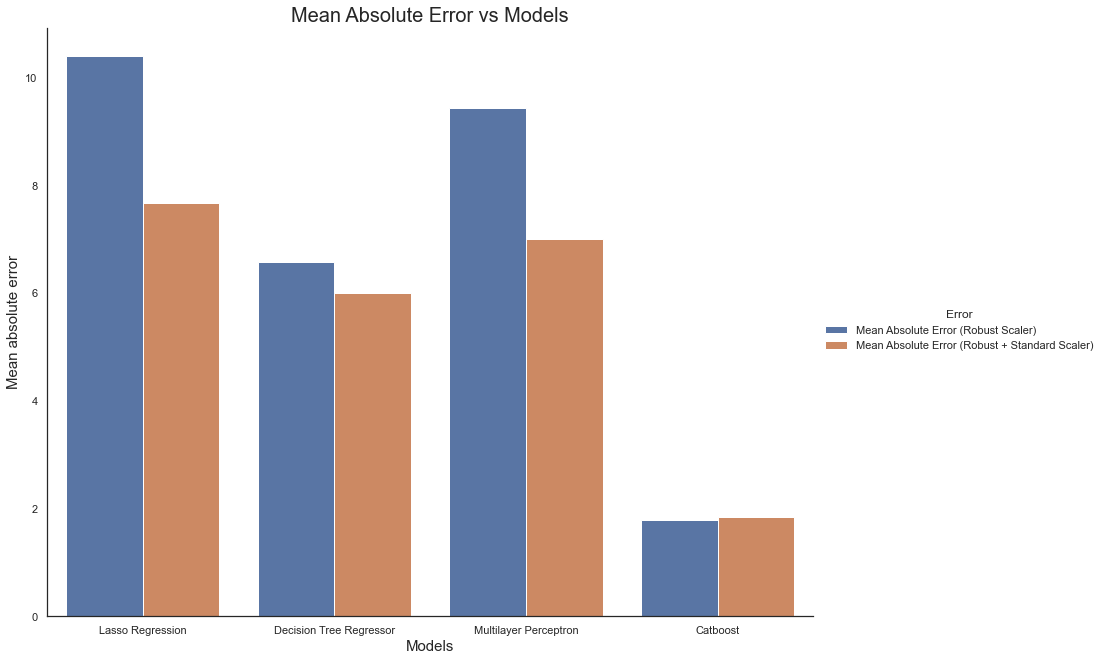

In [913]:
sns.catplot(ax = ax, x='index', y='Value', hue='Error', data=result_df_melt, kind='bar', height = 9, aspect = 11.7/9)
plt.title('Mean Absolute Error vs Models', fontsize = 20)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Mean absolute error', fontsize = 15)
plt.show()

## SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Resource: https://github.com/slundberg/shap

0:	learn: 18.1603620	total: 16.3ms	remaining: 5.21s
1:	learn: 16.4305912	total: 22.6ms	remaining: 3.6s
2:	learn: 15.0556698	total: 27.7ms	remaining: 2.94s
3:	learn: 13.9014279	total: 30.9ms	remaining: 2.44s
4:	learn: 12.8556879	total: 34ms	remaining: 2.15s
5:	learn: 12.0273005	total: 36.9ms	remaining: 1.94s
6:	learn: 11.2384054	total: 39.3ms	remaining: 1.76s
7:	learn: 10.5584887	total: 42.1ms	remaining: 1.65s
8:	learn: 9.9613551	total: 44.8ms	remaining: 1.55s
9:	learn: 9.5808319	total: 47ms	remaining: 1.46s
10:	learn: 9.1517134	total: 49.5ms	remaining: 1.4s
11:	learn: 8.7672104	total: 51.7ms	remaining: 1.33s
12:	learn: 8.4764346	total: 54.3ms	remaining: 1.28s
13:	learn: 8.2119668	total: 57.1ms	remaining: 1.25s
14:	learn: 7.9884585	total: 59.6ms	remaining: 1.22s
15:	learn: 7.7847413	total: 61.7ms	remaining: 1.18s
16:	learn: 7.6038519	total: 63.9ms	remaining: 1.14s
17:	learn: 7.4458897	total: 66.4ms	remaining: 1.12s
18:	learn: 7.3175946	total: 68.6ms	remaining: 1.09s
19:	learn: 7.1969968

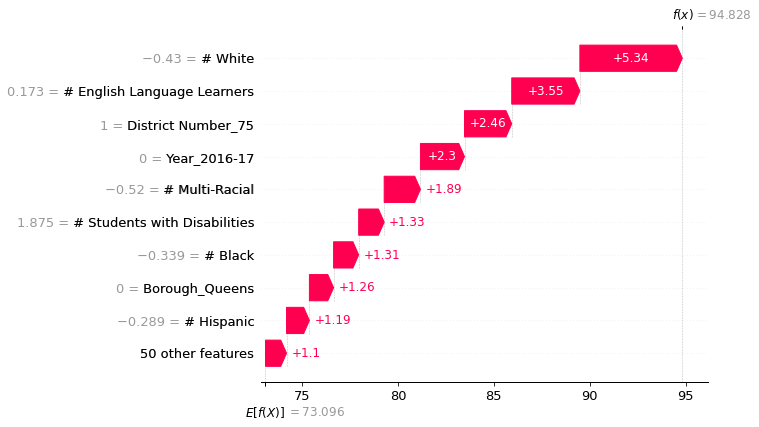

In [831]:
import shap

cat = CatBoostRegressor(learning_rate= 0.15815201490651834, n_estimators= 321, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train_sc, y_train)

explainer = shap.Explainer(cat)
shap_values = explainer(final_df_x_train_sc)

shap.plots.waterfall(shap_values[0])

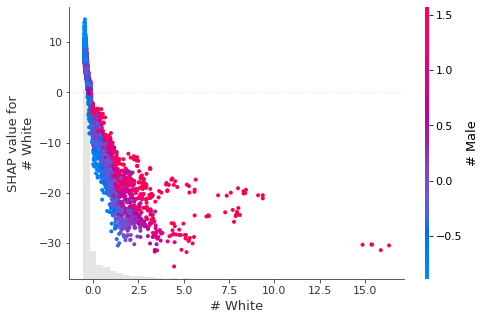

<Figure size 432x288 with 0 Axes>

In [832]:
shap.plots.scatter(shap_values[:,'# White'], color=shap_values)
plt.savefig('/users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/image/SHAP_bar.jpeg',bbox_inches='tight')

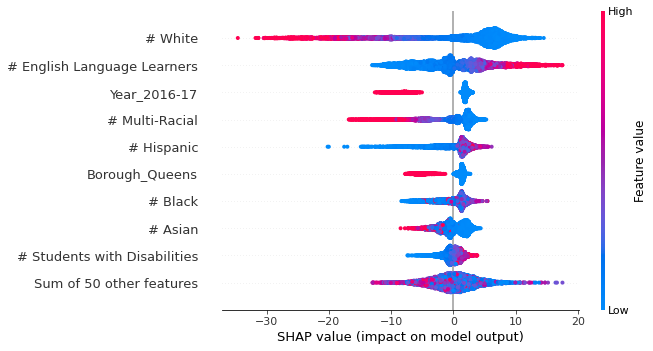

In [833]:
shap.plots.beeswarm(shap_values)

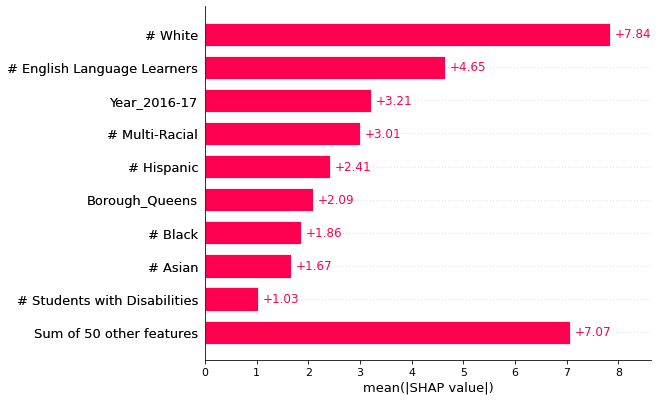

In [834]:
shap.plots.bar(shap_values)

## Choosing the right model.

CatBoost is the best model with MAE score of 1.79.

• Validation set MAE score: 1.6
• Test set MAE score: 1.79

With this highly accuracte model, we can predict the economic index by the corresponding values borough,grade,race in New York City. 

## Making adjustments of the results.

In [835]:
df_bronx = nyc_pandas[nyc_pandas['Borough'] == 'Bronx'].mean().reset_index().rename(columns = {'index':'index',0:'val'})

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [836]:
Staten_Island_bronx = nyc_pandas[nyc_pandas['Borough'] == 'Staten Island'].mean().reset_index().rename(columns = {'index':'index',0:'val'})

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


FixedFormatter should only be used together with FixedLocator


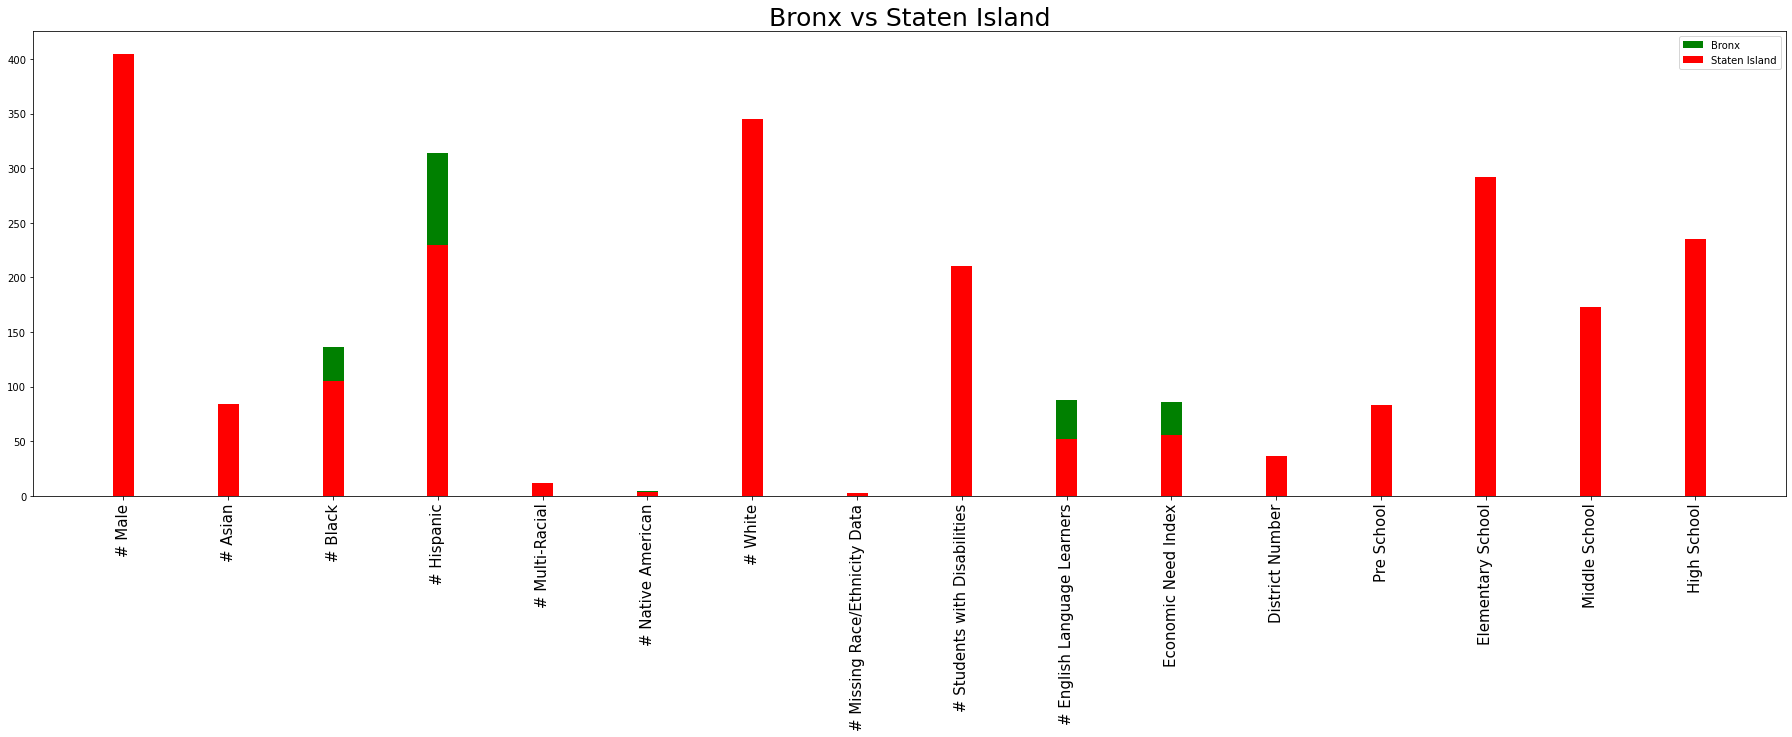

In [837]:
plt.figure(figsize=(25,10))
ax = plt.subplot(111)
width = 0.27
len_xaxis = len(Staten_Island_bronx['index'])

rects = ax.bar(df_bronx['index'], df_bronx['val'], width = 0.2, color = 'g')
rects2 = ax.bar(Staten_Island_bronx['index'], Staten_Island_bronx['val'], width = 0.2, color = 'r')

ax.legend(['Bronx','Staten Island'])
ax.set_xticklabels((Staten_Island_bronx['index']), rotation = 'vertical', fontsize = 15)

plt.tight_layout()

plt.title('Bronx vs Staten Island', fontsize= 25)
plt.savefig('/users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/image/Bronx_Staten.jpeg',bbox_inches='tight')


According to the graph, Bronx has 4 features that are different with State Island. Staten Island has the last economic Need Index which is 55 and the Bronx has most economic Nddex Index with 85. Therefore, we can make several assumtpions through this graph. 

If we reduce the number of Hispanic, Black, and English Language Learner in Bronx, would the economic need index decrease as well? 

To experiment this, we will use the x_test data and modify the amount of hispanic people, black people, and englush language learners in Bronx and see how theoretically decreaseing these features will influence the economic need index 

In [838]:
print("Mean value of white people in bronx:",final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]['# White'].mean())

Mean value of white people in bronx: -0.3478678077578059


In [839]:
print("Mean value of economic need index in bronx:", cat.predict(final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]).mean())

Mean value of economic need index in bronx: 84.12414882813297


# Case 1. If we increase the population of white:

In [840]:
def adjust(data):
    return data + 0.3

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
bronx_df.shape

(436, 59)

In [841]:
bronx_df['# White'] = bronx_df['# White'].apply(adjust)

bronx_df.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(436, 59)

In [846]:
print("Mean value of white people in bronx:",bronx_df[bronx_df['Borough_Bronx']==1.0]['# White'].mean())

Mean value of white people in bronx: -0.047867807757806496


In [847]:
print("mean value of economic need index after adjusting the scale for white people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())

mean value of economic need index after adjusting the scale for white people: 77.30306941769278


In [848]:
0.8409009758268968 -  0.7716624326511734

0.06923854317572342

decreased economic need index by 0.069

When we increase the amount of white people by scale of 0.3 in the given condition mean = 0 and std = 1, Economic Need Index will decrease meaning higher graduation rate of that school and the average poverty rate will decrease.

# Case 2: Reduce Black and Hispanic people in Bronx.

In [849]:
def reduce(data, x):
    return data - x

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average black people before reducing number of black people", bronx_df['# Black'].mean())

Average black people before reducing number of black people -0.10542368093441652


In [850]:
dic = {}

for i in np.arange(0.1,2.0,0.05):
    bronx_df['# Black'] = bronx_df['# Black'].apply(reduce, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 83.92978498695948,
 0.15000000000000002: 83.59438955198819,
 0.20000000000000004: 83.16756966298802,
 0.25000000000000006: 82.71010898225845,
 0.30000000000000004: 82.41936121181662,
 0.3500000000000001: 82.27387620775134,
 0.40000000000000013: 82.20243041128342,
 0.45000000000000007: 82.17158993332804,
 0.5000000000000001: 82.16635423121451,
 0.5500000000000002: 82.15764660165394,
 0.6000000000000002: 82.12760137442599,
 0.6500000000000001: 82.12357944501933,
 0.7000000000000002: 82.12755346433788,
 0.7500000000000002: 82.12596813008516,
 0.8000000000000002: 82.12713040661978,
 0.8500000000000002: 82.12713040661978,
 0.9000000000000002: 82.12713040661978,
 0.9500000000000003: 82.12713040661978,
 1.0000000000000004: 82.12713040661978,
 1.0500000000000003: 82.12713040661978,
 1.1000000000000005: 82.12713040661978,
 1.1500000000000004: 82.12713040661978,
 1.2000000000000004: 82.12713040661978,
 1.2500000000000004: 82.12713040661978,
 1.3000000000000005: 82.12713040661978,
 1.350000

no matter how much we reduce the number of black people, the economic need index stays the same

In [851]:
bronx_df['# Black'] = bronx_df['# Black'].apply(reduce, x = 0.4)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [852]:
print("Average black people after reducing number of black people", bronx_df['# Black'].mean())

Average black people after reducing number of black people -39.45542368093444


In [853]:
print("mean value of economic need index after cutting off 0.3 black people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())


mean value of economic need index after cutting off 0.3 black people: 82.12713040661978


In [854]:
0.8409009758268968 -  0.8259611707986514

0.014939805028245434

Decreased the econominc need index by 0.015 by decreasing the number of black people

In [855]:
def reduce(data, x):
    return data - x

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average Hispanic people before reducing number of Hispanic people", bronx_df['# Hispanic'].mean())
print("mean value of economic need index after adjusting the scale for white people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())

Average Hispanic people before reducing number of Hispanic people 0.37157377881720105
mean value of economic need index after adjusting the scale for white people: 84.12414882813297


In [856]:
dic = {}

for i in np.arange(0.1,2.0,0.05):
    bronx_df['# Hispanic'] = bronx_df['# Hispanic'].apply(reduce, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 83.98493857275263,
 0.15000000000000002: 83.7680285890659,
 0.20000000000000004: 83.15704893658493,
 0.25000000000000006: 82.09112799159217,
 0.30000000000000004: 80.49028971813615,
 0.3500000000000001: 78.6557311466431,
 0.40000000000000013: 77.1404871535894,
 0.45000000000000007: 76.10963522570268,
 0.5000000000000001: 75.55183485267814,
 0.5500000000000002: 75.21629096305652,
 0.6000000000000002: 75.04309210364485,
 0.6500000000000001: 75.0155424718032,
 0.7000000000000002: 75.00883162545392,
 0.7500000000000002: 74.98897197491296,
 0.8000000000000002: 74.94410633221379,
 0.8500000000000002: 74.94410633221379,
 0.9000000000000002: 74.94410633221379,
 0.9500000000000003: 74.94410633221379,
 1.0000000000000004: 74.94410633221379,
 1.0500000000000003: 74.94410633221379,
 1.1000000000000005: 74.94410633221379,
 1.1500000000000004: 74.94410633221379,
 1.2000000000000004: 74.94410633221379,
 1.2500000000000004: 74.94410633221379,
 1.3000000000000005: 74.94410633221379,
 1.3500000000

In [857]:
0.84-0.74

0.09999999999999998

The more value that is subtracted by 0.5, the more ineffective it is. Therefore we should set the x as 0.5 and will return a result with a decrease of 0.1 economic need index

# Case 3: Reduce English Learners in Bronx

Now let's see if the amount of english learners in Bronx actually influences the economic need index

In [858]:
bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average black people before reducing number of black people", bronx_df['# English Language Learners'].mean())
print("Average Economic Need Index of people in Bronx:", cat.predict(bronx_df).mean())


Average black people before reducing number of black people 0.0681912997351013
Average Economic Need Index of people in Bronx: 84.12414882813297


In [859]:
def reduce_english(data, x):
    return data - x

dic = {}

for i in np.arange(0.1,1.0,0.01):
    bronx_df['# English Language Learners'] = bronx_df['# English Language Learners'].apply(reduce_english, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 82.8954710584045,
 0.11: 81.47781689512226,
 0.12: 80.15411889753396,
 0.13: 78.79321896531494,
 0.13999999999999999: 77.80045584024228,
 0.14999999999999997: 76.9418694830215,
 0.15999999999999998: 76.35067740611589,
 0.16999999999999998: 75.96520089075027,
 0.17999999999999997: 75.60381835106053,
 0.18999999999999995: 75.3770119919902,
 0.19999999999999996: 75.151997726324,
 0.20999999999999996: 74.8670874379742,
 0.21999999999999995: 74.59380950345903,
 0.22999999999999995: 74.27922240525716,
 0.23999999999999994: 74.14401471131754,
 0.24999999999999992: 74.03133039820875,
 0.2599999999999999: 73.9593130998515,
 0.2699999999999999: 73.91122427427335,
 0.2799999999999999: 73.86741320281133,
 0.2899999999999999: 73.85708588787921,
 0.29999999999999993: 73.83772507114885,
 0.30999999999999994: 73.8119696575326,
 0.3199999999999999: 73.78166571308505,
 0.32999999999999985: 73.76769914228116,
 0.33999999999999986: 73.76769914228116,
 0.34999999999999987: 73.76769914228116,
 0.35999

From decreasing the economic need index from 84 to 76 by decreasing the scale of # English Learners by 0.15, the economic need index decreased by 0.08.

The main goal of this project was to build a predictive regression model that can predict the economc need index and make conclusions to inform the results to NYC.

### 3 possible solutions which can help decrease the economic need index. 

1. Increase the number of white people

• By increasing the white population by 0.1 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.069

2. Decrease the number of black and hispanic people

• By decreasing the black population by 0.3 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.015

• By decreasing the hispanic population by 0.15 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.1

3. Decrease the number of english learners

• By decreasing the english learners by 0.2 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.08